# SIMULATION OF THE LOAD SHED VOLTTRON AGENT IN FSM FORM

In [1]:
import os, sys, inspect, io
from transitions import *
from transitions.extensions import GraphMachine
from IPython.display import Image, display, display_png


class MakeChart():
    
    def show_graph(self, **kwargs):
        stream = io.BytesIO()
        self.get_graph(**kwargs).draw(stream, prog='dot', format='png')
        display(Image(stream.getvalue()))

class loadShedProgram(MakeChart):
    
    def __init__(self):
        
        self.bacnet_releases_complete = False
        self.bacnet_overrides_complete = False
        self.load_shed_status = False    
        self.building_occupied = False

In [2]:
transitions = [

    # APPLY BACnet commands: demand response event is True go into BACnet Override Mode from Standby mode
    {'trigger': 'update', 'source': 'Standby', 'dest': 'BACnet_Override', 'conditions':'load_shed_status', 'unless':['bacnet_overrides_complete','bacnet_releases_complete']},
    
    # WAIT OUT DR EVENT: demand response event is True, overrides have been applied, wait for event to expire
    {'trigger': 'update', 'source': 'BACnet_Override', 'dest': 'Wait_For_Expiration', 'conditions':['bacnet_overrides_complete','load_shed_status'],'unless':'bacnet_releases_complete'},
    
    # RELEASE BACnet commands: demand response event has expired by demand response event going False, BACnet Overrides True, BACnet Releases False
    {'trigger': 'update', 'source': 'Wait_For_Expiration', 'dest': 'BACnet_Release', 'conditions':'bacnet_overrides_complete','unless':['load_shed_status','bacnet_releases_complete']},    
    
    # WAIT for building to go Unnocupied to reset parameters
    {'trigger': 'update', 'source': 'BACnet_Release', 'dest': 'Wait_For_Unnocupied', 'conditions':['bacnet_overrides_complete','bacnet_releases_complete','building_occupied'],'unless':'load_shed_status'},
    
    # RESET programming parameters
    {'trigger': 'update', 'source': 'Wait_For_Unnocupied', 'dest': 'Reset_Params', 'conditions':['bacnet_overrides_complete','bacnet_releases_complete'],'unless':['building_occupied','load_shed_status']},
    
    # Go Back to STANDBY: program is ready for next demand response event
    {'trigger': 'update', 'source': 'Reset_Params', 'dest': 'Standby','unless':['bacnet_overrides_complete','bacnet_releases_complete','building_occupied','load_shed_status']}
]


states = ['Standby','BACnet_Override','Wait_For_Expiration','BACnet_Release','Wait_For_Unnocupied','Reset_Params']

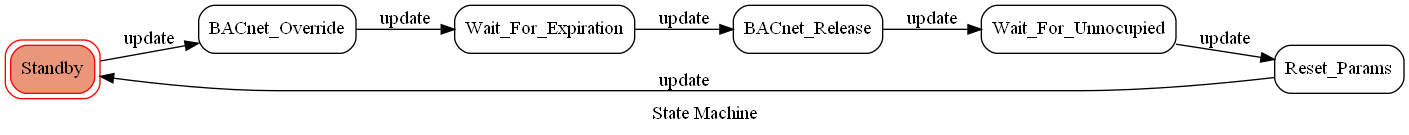

In [3]:
model = loadShedProgram()
machine = GraphMachine(model=model, states=states, transitions=transitions, initial='Standby')
model.show_graph()

In [4]:
print("The Finite State Machine is in: ", model.state)

The Finite State Machine is in:  Standby


# Simulate building going into Occupied mode 

* In the real world this would be a BACnet read to the BAS, like an AHU system went occupied True or some global BACnet Occ variable

In [5]:
model.building_occupied = True

# Simulate building is occupied and there is no demand response event

In [6]:
print("model.bacnet_releases_complete: ", model.bacnet_releases_complete)
print("model.bacnet_overrides_complete: ", model.bacnet_overrides_complete)
print("model.load_shed_status: ", model.load_shed_status)
print("model.building_occupied: ", model.building_occupied)

model.bacnet_releases_complete:  False
model.bacnet_overrides_complete:  False
model.load_shed_status:  False
model.building_occupied:  True


In [7]:
model.update()
print("The Finite State Machine is in: ", model.state)

The Finite State Machine is in:  Standby


# Simulate open ADR simple event True

In [8]:
model.load_shed_status = True

In [9]:
print("model.bacnet_releases_complete: ", model.bacnet_releases_complete)
print("model.bacnet_overrides_complete: ", model.bacnet_overrides_complete)
print("model.load_shed_status: ", model.load_shed_status)
print("model.building_occupied: ", model.building_occupied)

model.bacnet_releases_complete:  False
model.bacnet_overrides_complete:  False
model.load_shed_status:  True
model.building_occupied:  True


In [10]:
model.update()
print("The Finite State Machine is in: ", model.state)

The Finite State Machine is in:  BACnet_Override


* FSM (above) went into BACnet_Override state which is the global setpoint adjust of the VAV boxes in the HVAC BAS zone temperature setpoints

# Simulate that BACnet overrides have been applied to BAS, demand response event is still TRUE successfully, and the VOLTTRON agent program continues to check the API waiting for event to be False or payload signal == 0

In [11]:
model.bacnet_overrides_complete = True

In [12]:
print("model.bacnet_releases_complete: ", model.bacnet_releases_complete)
print("model.bacnet_overrides_complete: ", model.bacnet_overrides_complete)
print("model.load_shed_status: ", model.load_shed_status)
print("model.building_occupied: ", model.building_occupied)

model.bacnet_releases_complete:  False
model.bacnet_overrides_complete:  True
model.load_shed_status:  True
model.building_occupied:  True


In [13]:
model.update()
print("The Finite State Machine is in: ", model.state)

The Finite State Machine is in:  Wait_For_Expiration


* FSM above went back to "Wait_For_Expiration" state after BACnet global setpoint adjust commands have been successfully implemented, just need to wait out the demand response event

# Simulate demand response event expired

In [14]:
model.load_shed_status = False

In [15]:
print("model.bacnet_releases_complete: ", model.bacnet_releases_complete)
print("model.bacnet_overrides_complete: ", model.bacnet_overrides_complete)
print("model.load_shed_status: ", model.load_shed_status)
print("model.building_occupied: ", model.building_occupied)

model.bacnet_releases_complete:  False
model.bacnet_overrides_complete:  True
model.load_shed_status:  False
model.building_occupied:  True


* note above overrides are still on the BAS and we now need to release them

In [16]:
model.update()
print("The Finite State Machine is in: ", model.state)

The Finite State Machine is in:  BACnet_Release


* program went into BACnet release as expected

# Simulate BACnet release of BAS successful

In [17]:
model.bacnet_releases_complete = True

In [18]:
print("model.bacnet_releases_complete: ", model.bacnet_releases_complete)
print("model.bacnet_overrides_complete: ", model.bacnet_overrides_complete)
print("model.load_shed_status: ", model.load_shed_status)
print("model.building_occupied: ", model.building_occupied)

model.bacnet_releases_complete:  True
model.bacnet_overrides_complete:  True
model.load_shed_status:  False
model.building_occupied:  True


In [19]:
model.update()
print("The Finite State Machine is in: ", model.state)

The Finite State Machine is in:  Wait_For_Unnocupied


* note so the building systems would be a in a "rebound" mode HVAC system back to normal, wait out for the building to go unnocupied to reset params

# Simulate building going to Unnocupied Mode as defined from BAS

In [20]:
model.building_occupied = False

In [21]:
print("model.bacnet_releases_complete: ", model.bacnet_releases_complete)
print("model.bacnet_overrides_complete: ", model.bacnet_overrides_complete)
print("model.load_shed_status: ", model.load_shed_status)
print("model.building_occupied: ", model.building_occupied)

model.bacnet_releases_complete:  True
model.bacnet_overrides_complete:  True
model.load_shed_status:  False
model.building_occupied:  False


In [22]:
model.update()
print("The Finite State Machine is in: ", model.state)

The Finite State Machine is in:  Reset_Params


* now that the building is unnocupied HVAC is off, reset all params

In [23]:
model.bacnet_overrides_complete = False
model.bacnet_releases_complete = False

In [24]:
model.update()
print("The Finite State Machine is in: ", model.state)

The Finite State Machine is in:  Standby


# READY for next event